# Introduction to Random Forest Classifiers

A Random Forest Classifier is an ensemble method which means that its final output is a result of multiple different algorithms and therefore uses the logic of the crowd is more accurate than the individual. For this, it uses the Decision Tree Classifier that we encountered last seminar, creating multiple trees that work on subest of the data and aggregating the final result in creating predictions. 

The advantages of this method are that:
- Easy to understand 
- You can extract the structure by looking at individual trees
- Able to hand numerical and categorical data
- Reduces variance by combing diverse trees

The disadvantages:
- A large number of trees can make the algorithm too slow for real-time predictions in some cases

So you can see that it is highly useful with limited downside.


## The Data

The data that we will be looking at is the 2018-2019 NBA season and seeing if we can correctly classify each player into their listed position. This includes: PG, SG, SF, PF and C.

Therefore first of all we need to load in the data and inspect it.

In [1]:
import pandas as pd

NBA = pd.read_csv("Data/NBA_tot.txt", sep=",", header = 0)

We want to see what columns are contained within the data so that we can remove any values that aren't necessary

In [2]:
print(NBA.columns.values)

['Rk' 'Player' 'Pos' 'Age' 'Tm' 'G' 'GS' 'MP' 'FG' 'FGA' 'FG%' '3P' '3PA'
 '3P%' '2P' '2PA' '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB' 'DRB' 'TRB' 'AST'
 'STL' 'BLK' 'TOV' 'PF' 'PTS']


In this case we can drop the `Rk`, `Age`, `Tm`, `GS` ase these are not expected to be related to position and thus are not important going forward.

In [3]:
NBA.drop(columns =["Rk", "Age", "Tm", "GS"], inplace=True)

We then want to consider our target variable and how that is distributed and whether there may be any issues. We do this through a bar plot as we know that it is a discrete variable that takes on given categories.


Text(0, 0.5, 'Position')

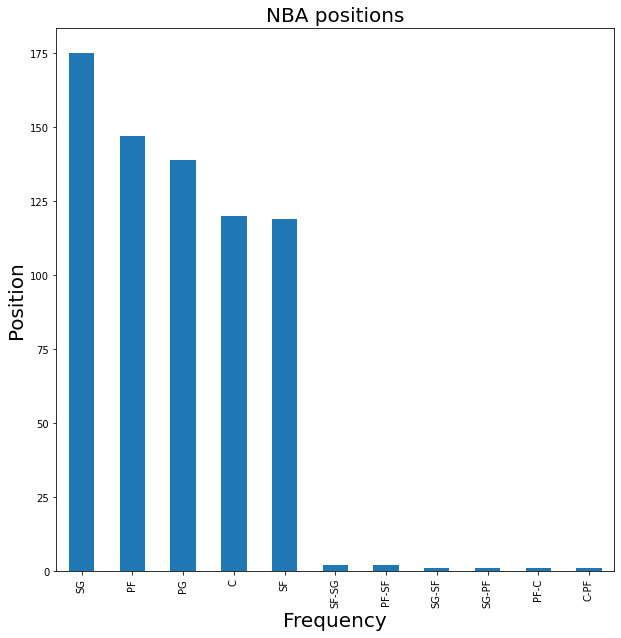

In [4]:
import matplotlib.pyplot as plt


pos = NBA.Pos.value_counts()
plt.subplots(figsize=(10, 10))
pos.plot(kind="bar")
plt.title("NBA positions", fontsize=20 )
plt.xlabel("Frequency", fontsize =20)
plt.ylabel("Position", fontsize=20 )

From this we can see that while SG, PF, PG, C and SF are all represented we have a few instances of players having two positions. The fact that these are so small means that we could potentially leave them out and drop them, but in our case we will try to clean them up on the basis that the first position identified will be their primary position.

We must thus inspect these outliers to see how appear.

In [5]:
NBA[NBA.Pos.isin(["PF-SF", "SF-SG","SG-PF","SG-SF", "PF-C", "C-PF"])]

,Player,Pos,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
38,Harrison Barnes\barneha02,PF-SF,77,2533,431,1027,0.420,174,441,0.395,...,0.824,57,304,361,115,50,13,98,122,1265
102,Jimmy Butler\butleji01,SF-SG,65,2185,418,904,0.462,67,193,0.347,...,0.855,121,221,342,263,123,39,95,111,1215
128,Wilson Chandler\chandwi01,PF-SF,51,1177,114,273,0.418,59,158,0.373,...,0.720,48,167,215,82,25,21,46,123,305
378,Kyle Korver\korveky01,SG-PF,70,1334,201,483,0.416,138,348,0.397,...,0.822,9,153,162,81,25,12,59,106,600
426,Thon Maker\makerth01,C-PF,64,972,109,268,0.407,49,153,0.320,...,0.667,41,161,202,45,21,51,33,105,323
436,Wesley Matthews\matthwe02,SF-SG,69,2091,279,698,0.400,150,403,0.372,...,0.810,32,138,170,160,54,17,91,160,840
600,Jonathon Simmons\simmojo02,SG-SF,56,1064,133,350,0.380,28,104,0.269,...,0.742,27,99,126,128,29,15,68,89,366
611,Jason Smith\smithja02,PF-C,20,190,21,59,0.356,9,26,0.346,...,0.875,16,36,52,14,3,7,13,30,65


We can thus use the apply function to be able to alter these results so that they show their primary position.

In [6]:
NBA["Pos"]= NBA["Pos"].apply(lambda x: x.split("-")[0] if "-" in x else x)

And check the results to see how they are distributed, expecting that this won't be too different to the plot above but that the double positions will be removed.

Text(0, 0.5, 'Position')

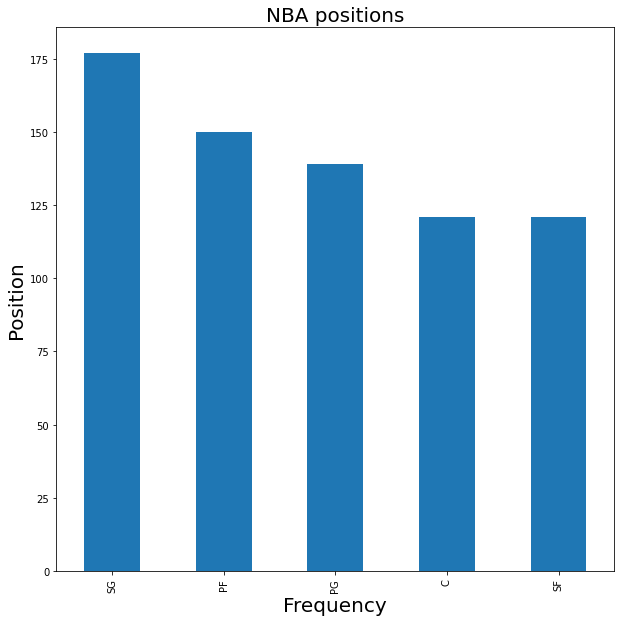

In [7]:
pos = NBA.Pos.value_counts()
plt.subplots(figsize=(10, 10))
pos.plot(kind="bar")
plt.title("NBA positions", fontsize=20 )
plt.xlabel("Frequency", fontsize =20)
plt.ylabel("Position", fontsize=20 )

The next issue is seeing if any players are duplicated because they siwtched throughout the season. From this we can see that there are 86 duplicated players. If we analyse these keeping teh duplciated players then this can potentially bias the results if they tilt the distribution towards a specific position. Therefore, we want to be able to remove the duplicates and put all the stats into a single row. 

In [8]:
duplicated_players = list(NBA[NBA.Player.duplicated(keep=False)].Player.unique())
print(len(duplicated_players))

86


To do this we need to check the columns and see how we may be able to aggregate them.

In [9]:
print(NBA.columns.values)

['Player' 'Pos' 'G' 'MP' 'FG' 'FGA' 'FG%' '3P' '3PA' '3P%' '2P' '2PA'
 '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB' 'DRB' 'TRB' 'AST' 'STL' 'BLK' 'TOV'
 'PF' 'PTS']


The percentage columns will need to be dropped and we need to aggregate based on sum, and in the case of position, we will assume that the first position that is listed for that player remains the same.

In [10]:
NBA.drop(columns = ["3P%", "2P%", "FT%", "eFG%", "FG%"], inplace = True)

In [11]:
not_sum = ["Player", "Pos"]
agg_fun = {x: "sum" for x in [y for y in list(NBA.columns.values) if y not in not_sum]}
agg_fun["Pos"] = "first"


NBA = NBA.groupby(["Player"]).agg(agg_fun).reset_index()

We then want to check to see if any player, after aggregating, has limited number of games, say less than a quarter of the season. This may suggest that they got injured and so their numbers may be not representative, or that they were dropped part way through the season and as such have little importance to our analysis.

<AxesSubplot:>

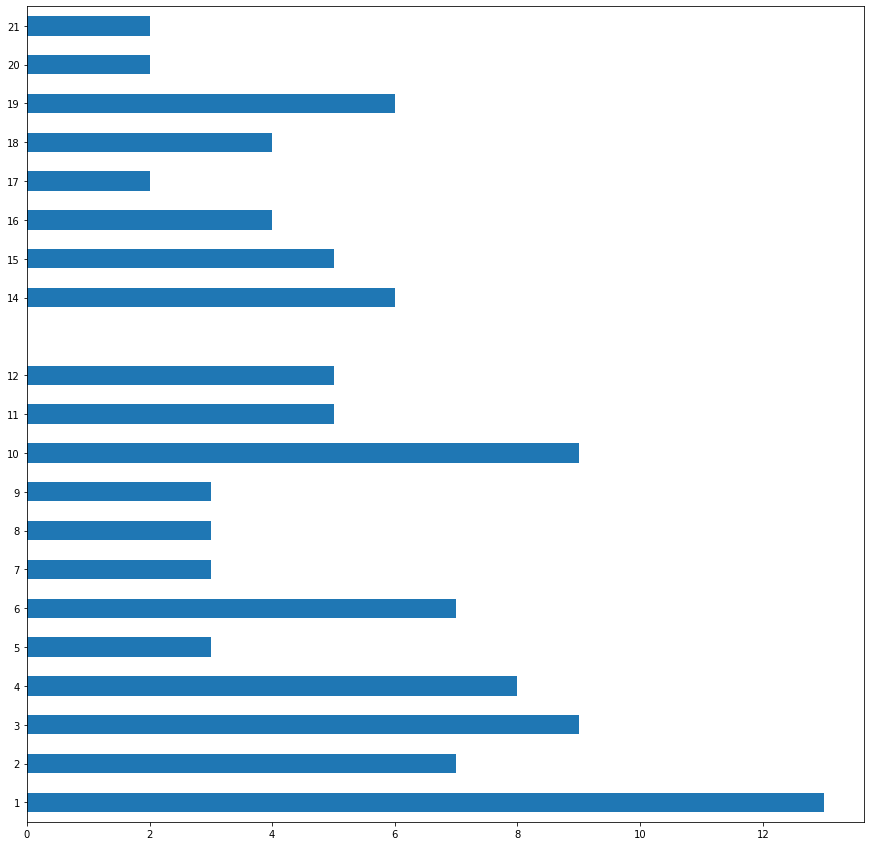

In [12]:
NBA[NBA.G <= 21].G.value_counts().plot(kind="barh", figsize=(15,15))

We can see from this distribution, and the value below, that a significnat number of players played less than 21 games. Given this number we can keep them for now but we need to be aware of how this may affect the results going forward.

In [13]:
count = 0
half_games = dict(NBA[NBA.G <= 21].G.value_counts())
for x in half_games.values():
    count += x

print(count)

106


Finally, we want to be able to add back in our percentage columns, that includes field goal percentage, 2P percentage, 3P percentage, free throw percentage and effective field goald percentage.

In [14]:
print(NBA.columns.values)

['Player' 'G' 'MP' 'FG' 'FGA' '3P' '3PA' '2P' '2PA' 'FT' 'FTA' 'ORB' 'DRB'
 'TRB' 'AST' 'STL' 'BLK' 'TOV' 'PF' 'PTS' 'Pos']


In [15]:
perc_cols = ["3P%", "2P%", "FT%", "FG%"]
for perc in perc_cols:
    made = str(perc[0:2])
    attempt = str(perc[0:2]) + "A"
    NBA[perc] = NBA[made]/NBA[attempt]

NBA["eFG%"] = (NBA["2P"] + 0.5*NBA["3P"])/NBA["FG"]

perc_cols.append("eFG%")

for x in perc_cols:
    NBA[x] = NBA[x].fillna(0)

Finally, given that these values are totals, apart form the percentage columns, they may be influenced by the number of games a player has played and how many minutes. For example, a star player may play a large number of games and minutes and thus will influence the game more than a role player at their position. A way to solve this is to divide each column by the minutes that a player plays so that the values are standardised to a degree. 

The results may show the efficiency of a player, but there is likely to be less variance than the overall results and so this should improve our analysis.

In [16]:
for x in [x for x in NBA.columns.values if x not in ["Player", "G", "MP", "Pos", "3P%", "2P%", "FT%", "FG%", "eFG%"]]:
    NBA[x] = NBA[x]/NBA["MP"]

In [17]:
NBA.describe()

,G,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,STL,BLK,TOV,PF,PTS,3P%,2P%,FT%,FG%,eFG%
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,...,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,57.284906,1298.788679,0.154447,0.349445,0.041669,0.126529,0.112779,0.222915,0.062338,0.085013,...,0.031503,0.020024,0.052540,0.093216,0.412901,0.290279,0.491182,0.696771,0.439919,0.834618
std,35.407644,1051.133834,0.066636,0.111823,0.031308,0.084985,0.068961,0.109564,0.042405,0.054207,...,0.021052,0.020825,0.028753,0.041697,0.161563,0.149377,0.123924,0.214882,0.111814,0.163158
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,359.750000,0.120455,0.280456,0.018440,0.075461,0.069978,0.151091,0.033588,0.048913,...,0.021249,0.006711,0.035316,0.068950,0.323163,0.256824,0.453396,0.651580,0.402209,0.780730
50%,60.000000,1174.000000,0.147179,0.333874,0.042946,0.129738,0.102885,0.214913,0.056115,0.075772,...,0.029262,0.014380,0.048714,0.087582,0.398168,0.331550,0.500000,0.750000,0.438788,0.854026
75%,77.000000,2056.250000,0.187364,0.406053,0.059982,0.178306,0.148404,0.288225,0.083848,0.112659,...,0.038296,0.025641,0.064918,0.112943,0.495295,0.367566,0.552796,0.818182,0.489598,0.924928
max,164.000000,5694.000000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.333333,0.363636,...,0.250000,0.166667,0.250000,0.461538,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can then remove the columns that we are not interested in analysing.

In [18]:
NBA.drop(columns = ["Player", "G", "MP"], inplace = True)

And begin to inspect our data in terms of the factors that may influence the analyis. This includes taking a look at any variables that may be correlated with each other anf thus unduly influence the analysis.

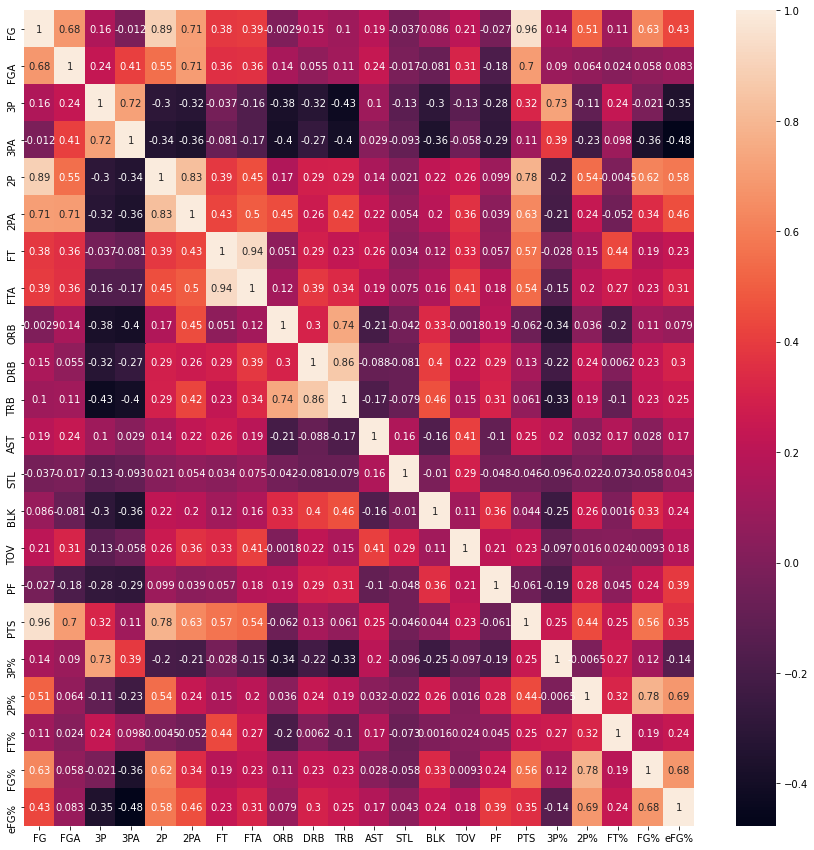

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = NBA.corr()
f, (ax) = plt.subplots(figsize=(15,15))
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()


From this plot we can see that there are some variables that are highly correlated with each other. The solution we adopt here is to drop any columns that think may be less influential in our analysis or capture broader trends which other values may be able to differentiate between positions better.

In [20]:
NBA.drop(columns = ["FG", "FGA", "FG%", "FTA", "2PA", "3PA"], inplace = True)

We then want to extract the data that we will actually perform the classifier on. This means seperating it out into our X and Y values.

In [21]:
X = NBA.drop(columns = ["Pos"])
y = NBA.Pos

Which we then seperate into out train and test values for by y and x. We do this to ensure that the algorithm is not overfitting and see how it performs on unseen data.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Dummy Classifier

In using the Random Forest Classifier we want to be able to test this against a baseline and we can do that by creating a dummy classifier. This dummy classifier makes decision based on simple decision rules, which in this case appears to be simply put all players into a shooting guard position, and thus has a relatively low accuracy of 0.28. This is our benchmark for going forward and analysing the results


In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics


dc = DummyClassifier(strategy='most_frequent', random_state = 42)
dc.fit(X_train,y_train) 
dc_preds = dc.predict(X_test)
print (metrics.classification_report(y_test, dc_preds))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00        25
          PF       0.00      0.00      0.00        24
          PG       0.00      0.00      0.00        27
          SF       0.00      0.00      0.00        20
          SG       0.28      1.00      0.44        37

    accuracy                           0.28       133
   macro avg       0.06      0.20      0.09       133
weighted avg       0.08      0.28      0.12       133



C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest Classifier

The random forest classifier algorithm creates many trees instead of just one to understand the dataset. This means that it is an ensemble method such that the final prediction of the random forest are made by averaging the predictions of each individual tree and thus follows the logic of the performance of the crowd is better than the performance of the individual. These individual trees are also based on randomly selected subsets of the data as well rather than the whole dataset.

This does so by taking advantage of:

1. Random Sampling of training datapoints when building trees
    - Each tree lerns from a random sample of the data points. These random smaples are drawn without replacement, known as bootstrapping
    - The idea if that by training each tree on different samples, although each tree might have high variance with resepct to a particular set of the training data, overall the entire forest will have lower variance, but not at the cost of increasing bias
    - When testing, predictions are made by avcearging the predictions of each decision tree
    

2. Random subsets of features considered when splitting nodes
    -  only a subset of all the features are considered for splitting each node in each decision tree

This requires you to specify `n_estimators` which specifies how many trees should be considered in the construction of the whole forest. The more trees chosen, the longer this will take

The benefit of this is that it injects some randomness into the fitting of trees to reduce overfitting that can be seen as part of decision trees, and hence produces and overall better model.

The first thing we want to do is to import the RandomForestClassifier algorithm, which is taken from the sklearn.ensemble module as seen below. We can then assign that Random Forest Classifier to a variable which we can latter call to apply to the data.


In [24]:
#import the classifier
from sklearn.ensemble import RandomForestClassifier

#attach the classifier to a variable
clf = RandomForestClassifier()


While this may be simply applied to our data using `.fit(x,y)` we can influence how it perfroms by using some of its parameters, similar to how we used `max_depth` in the Decision Tree Classifier workshop. 

The potential parameters include:
`n_estimators,
criterion,
max_features,
max_depth,
min_samples_split,
min_samples_leaf,
min_weight_leaf,
min_weight_fraction_leaf,
max_leaf_nodes,
min_impurity_decrease,
bootstrap,
oob_score,
n_jobs,
random_state,
verbose,
warm_start,
class_weight`

But for our purpose we will focuse on `n_estimators` and `max_depth`. `n_estimators` is the number of trees that you want to generate, which in this case we will generate 100 decision trees, and `max_depth` which as in the previous workshop, will limit the potential of overfitting of each individual tree, allow us to visualise the results and reduce computational complexity. 

We also set `oob_score` to true as we want to calculate the out of bag score which is used essentially for cross-sampling so we can more clearly see how it performs on the test data


More information on each parameter can be found [here](https://medium.com/@taplapinger/tuning-a-random-forest-classifier-1b252d1dde92) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

For our purposes we can stick with the default criterion for spliting as <b>gini</b> for gini impurity, but this can also be changed to 'entropy' if you wanted to see how the model performs. 


In [25]:
clf = RandomForestClassifier(n_estimators =100, oob_score=True, max_depth =3,
                            random_state = 42)

#fit it to the training data
clf.fit(X_train, y_train)
#extract the predictions
test_pred_random_forest = clf.predict(X_test)
    

In [26]:
y_test.value_counts()

SG    37
PG    27
C     25
PF    24
SF    20
Name: Pos, dtype: int64

In [27]:

# get the confusion matrix
confusion_matrix2 = metrics.confusion_matrix(y_test, test_pred_random_forest)
confusion_matrix2

array([[22,  3,  0,  0,  0],
       [ 5, 17,  1,  0,  1],
       [ 2,  1, 18,  0,  6],
       [ 0,  8,  0,  3,  9],
       [ 0,  2,  7,  3, 25]], dtype=int64)

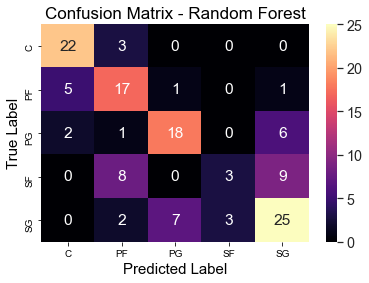

<Figure size 864x864 with 0 Axes>

In [28]:
matrix2_df = pd.DataFrame(confusion_matrix2)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3) # for label size
plt.figure(figsize=(12,12))

plot = sns.heatmap(matrix2_df, annot=True, fmt='g', ax=ax, cmap = "magma") #fmt so that numbers aren't scientific

#axis labels and title
ax.set_title('Confusion Matrix - Random Forest', fontsize = 17)
ax.set_xlabel('Predicted Label', fontsize = 15)
ax.set_ylabel('True Label'     , fontsize = 15)

# change tick labels from 0-4 to 1-5
labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()


We can see here that our model shows that it is not very good at predicting small forwards and shooting guards, but it is better at being able to predict centres and powerforwards. Do you have any idea why this may be?

We can start to understand this by looking at some of the decisions trees that are created, to see how the random forest may be reaching its decisions.

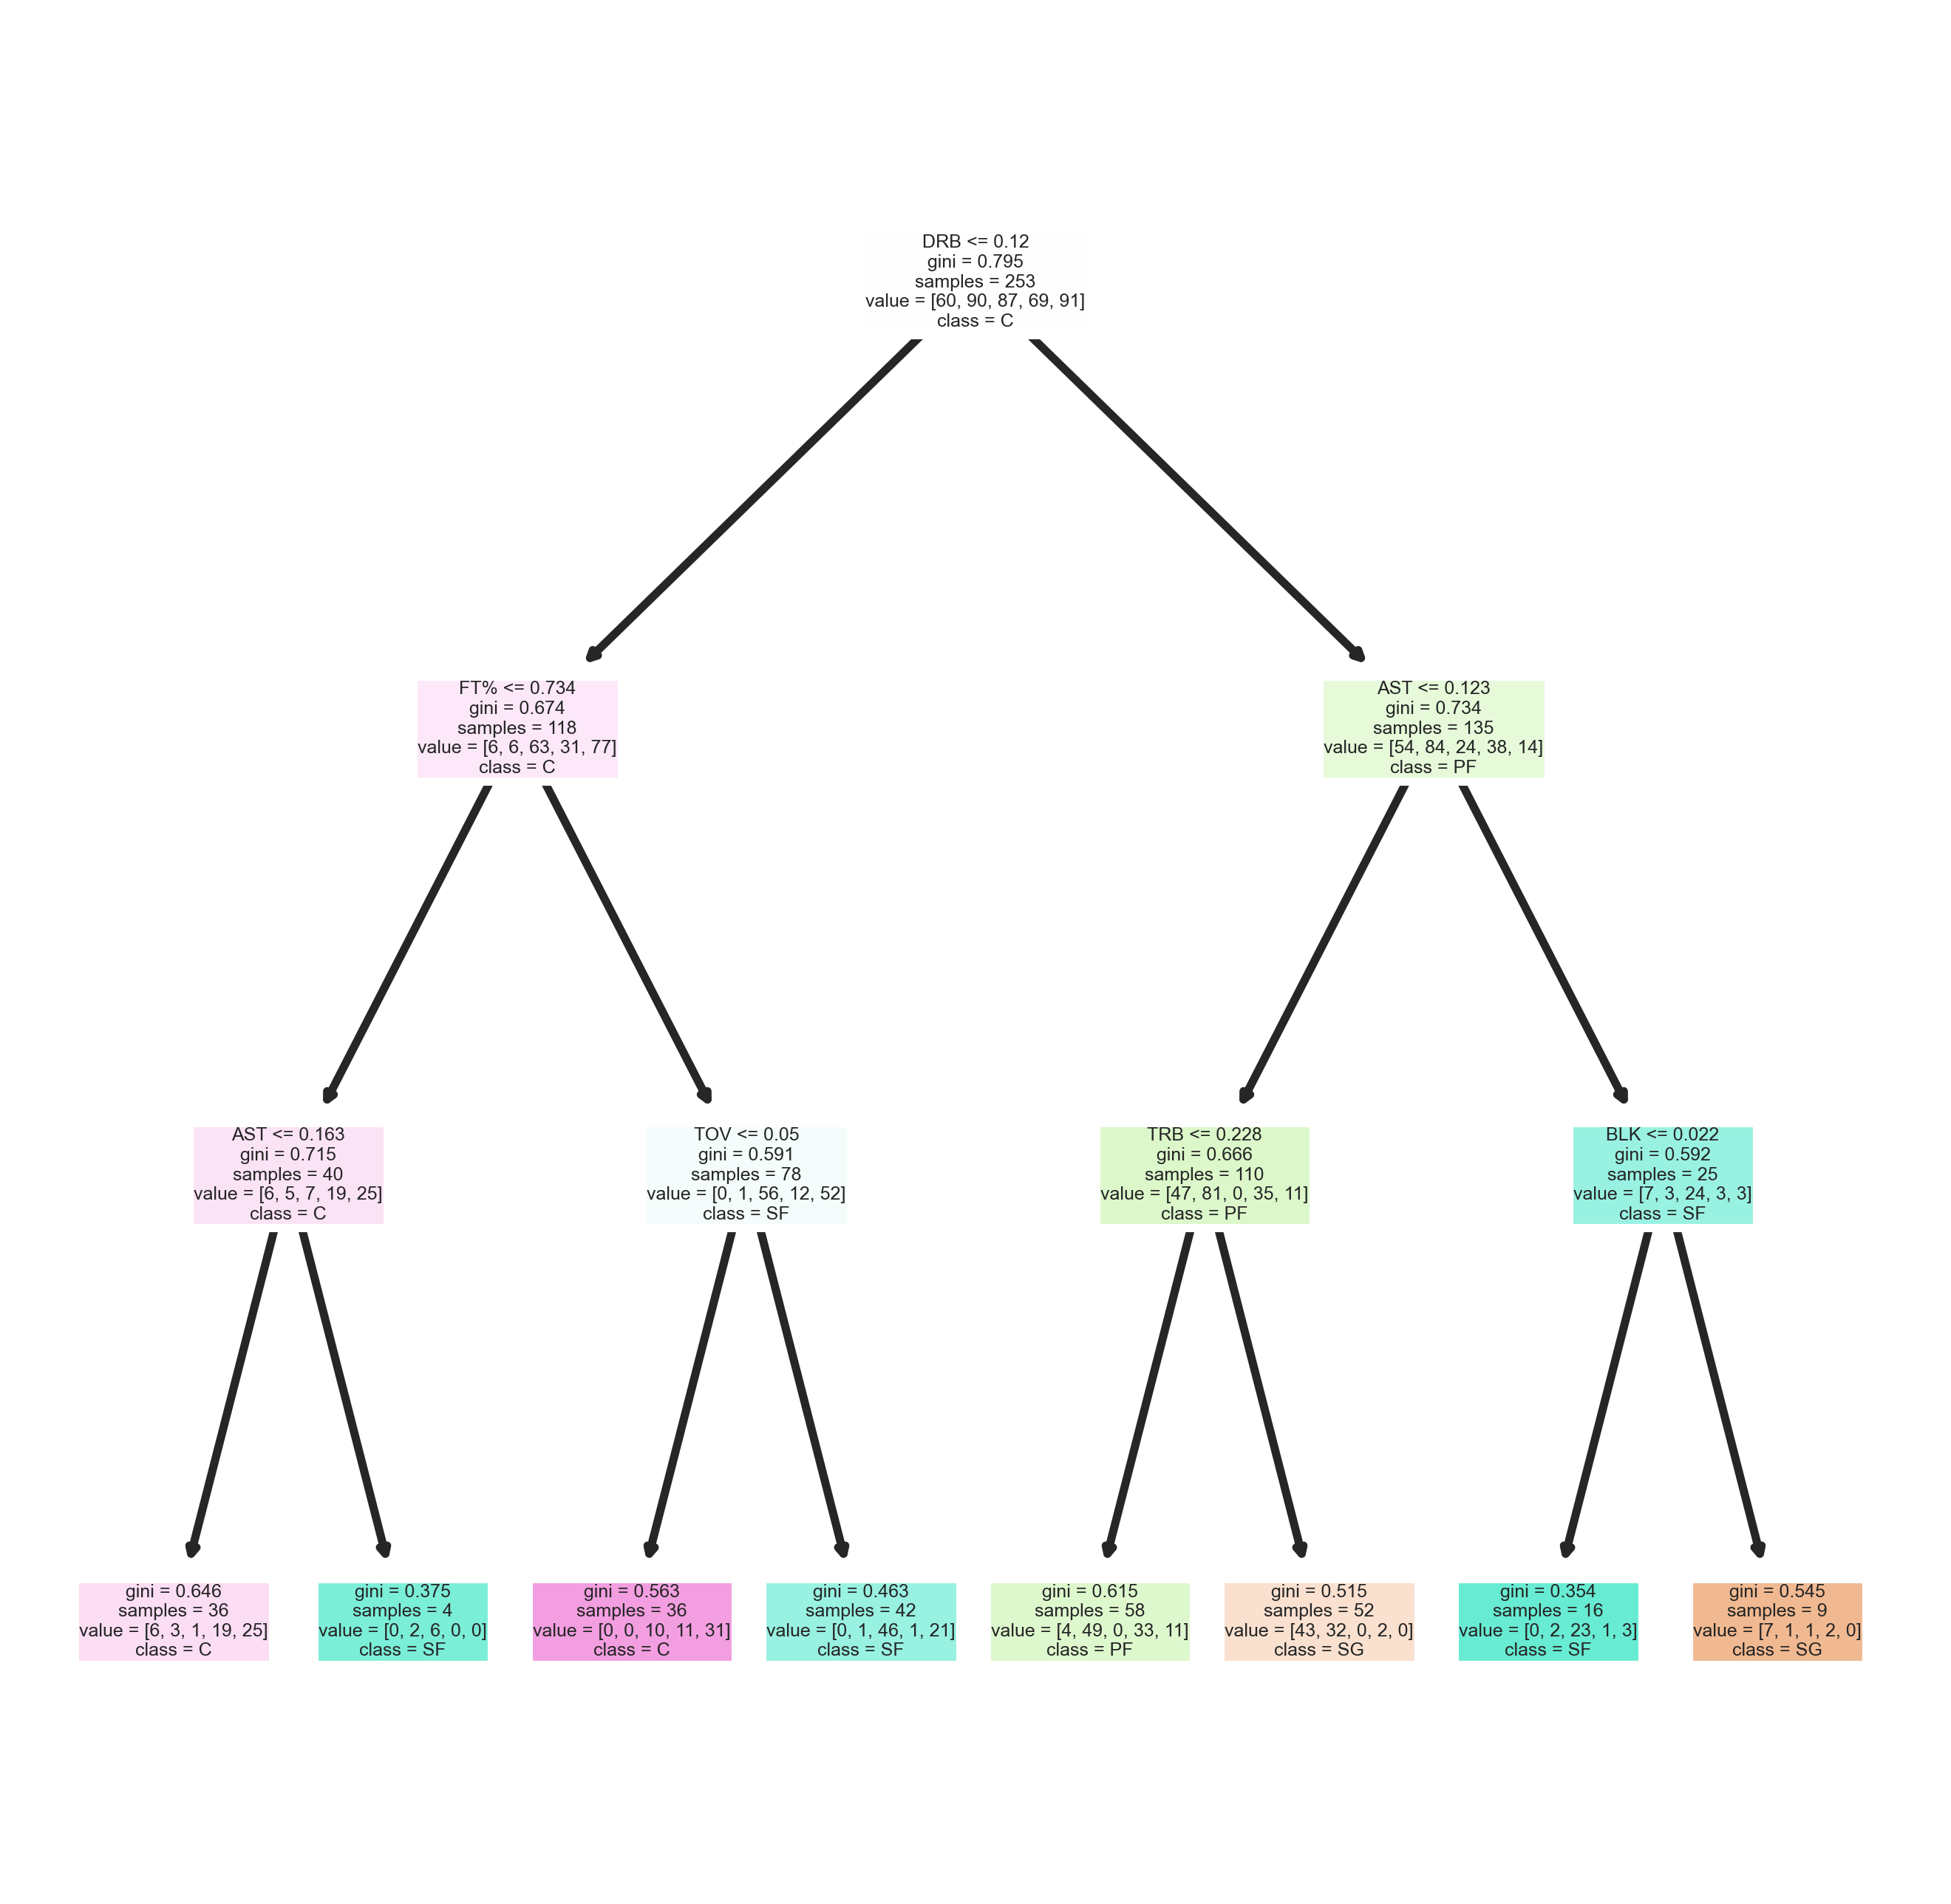

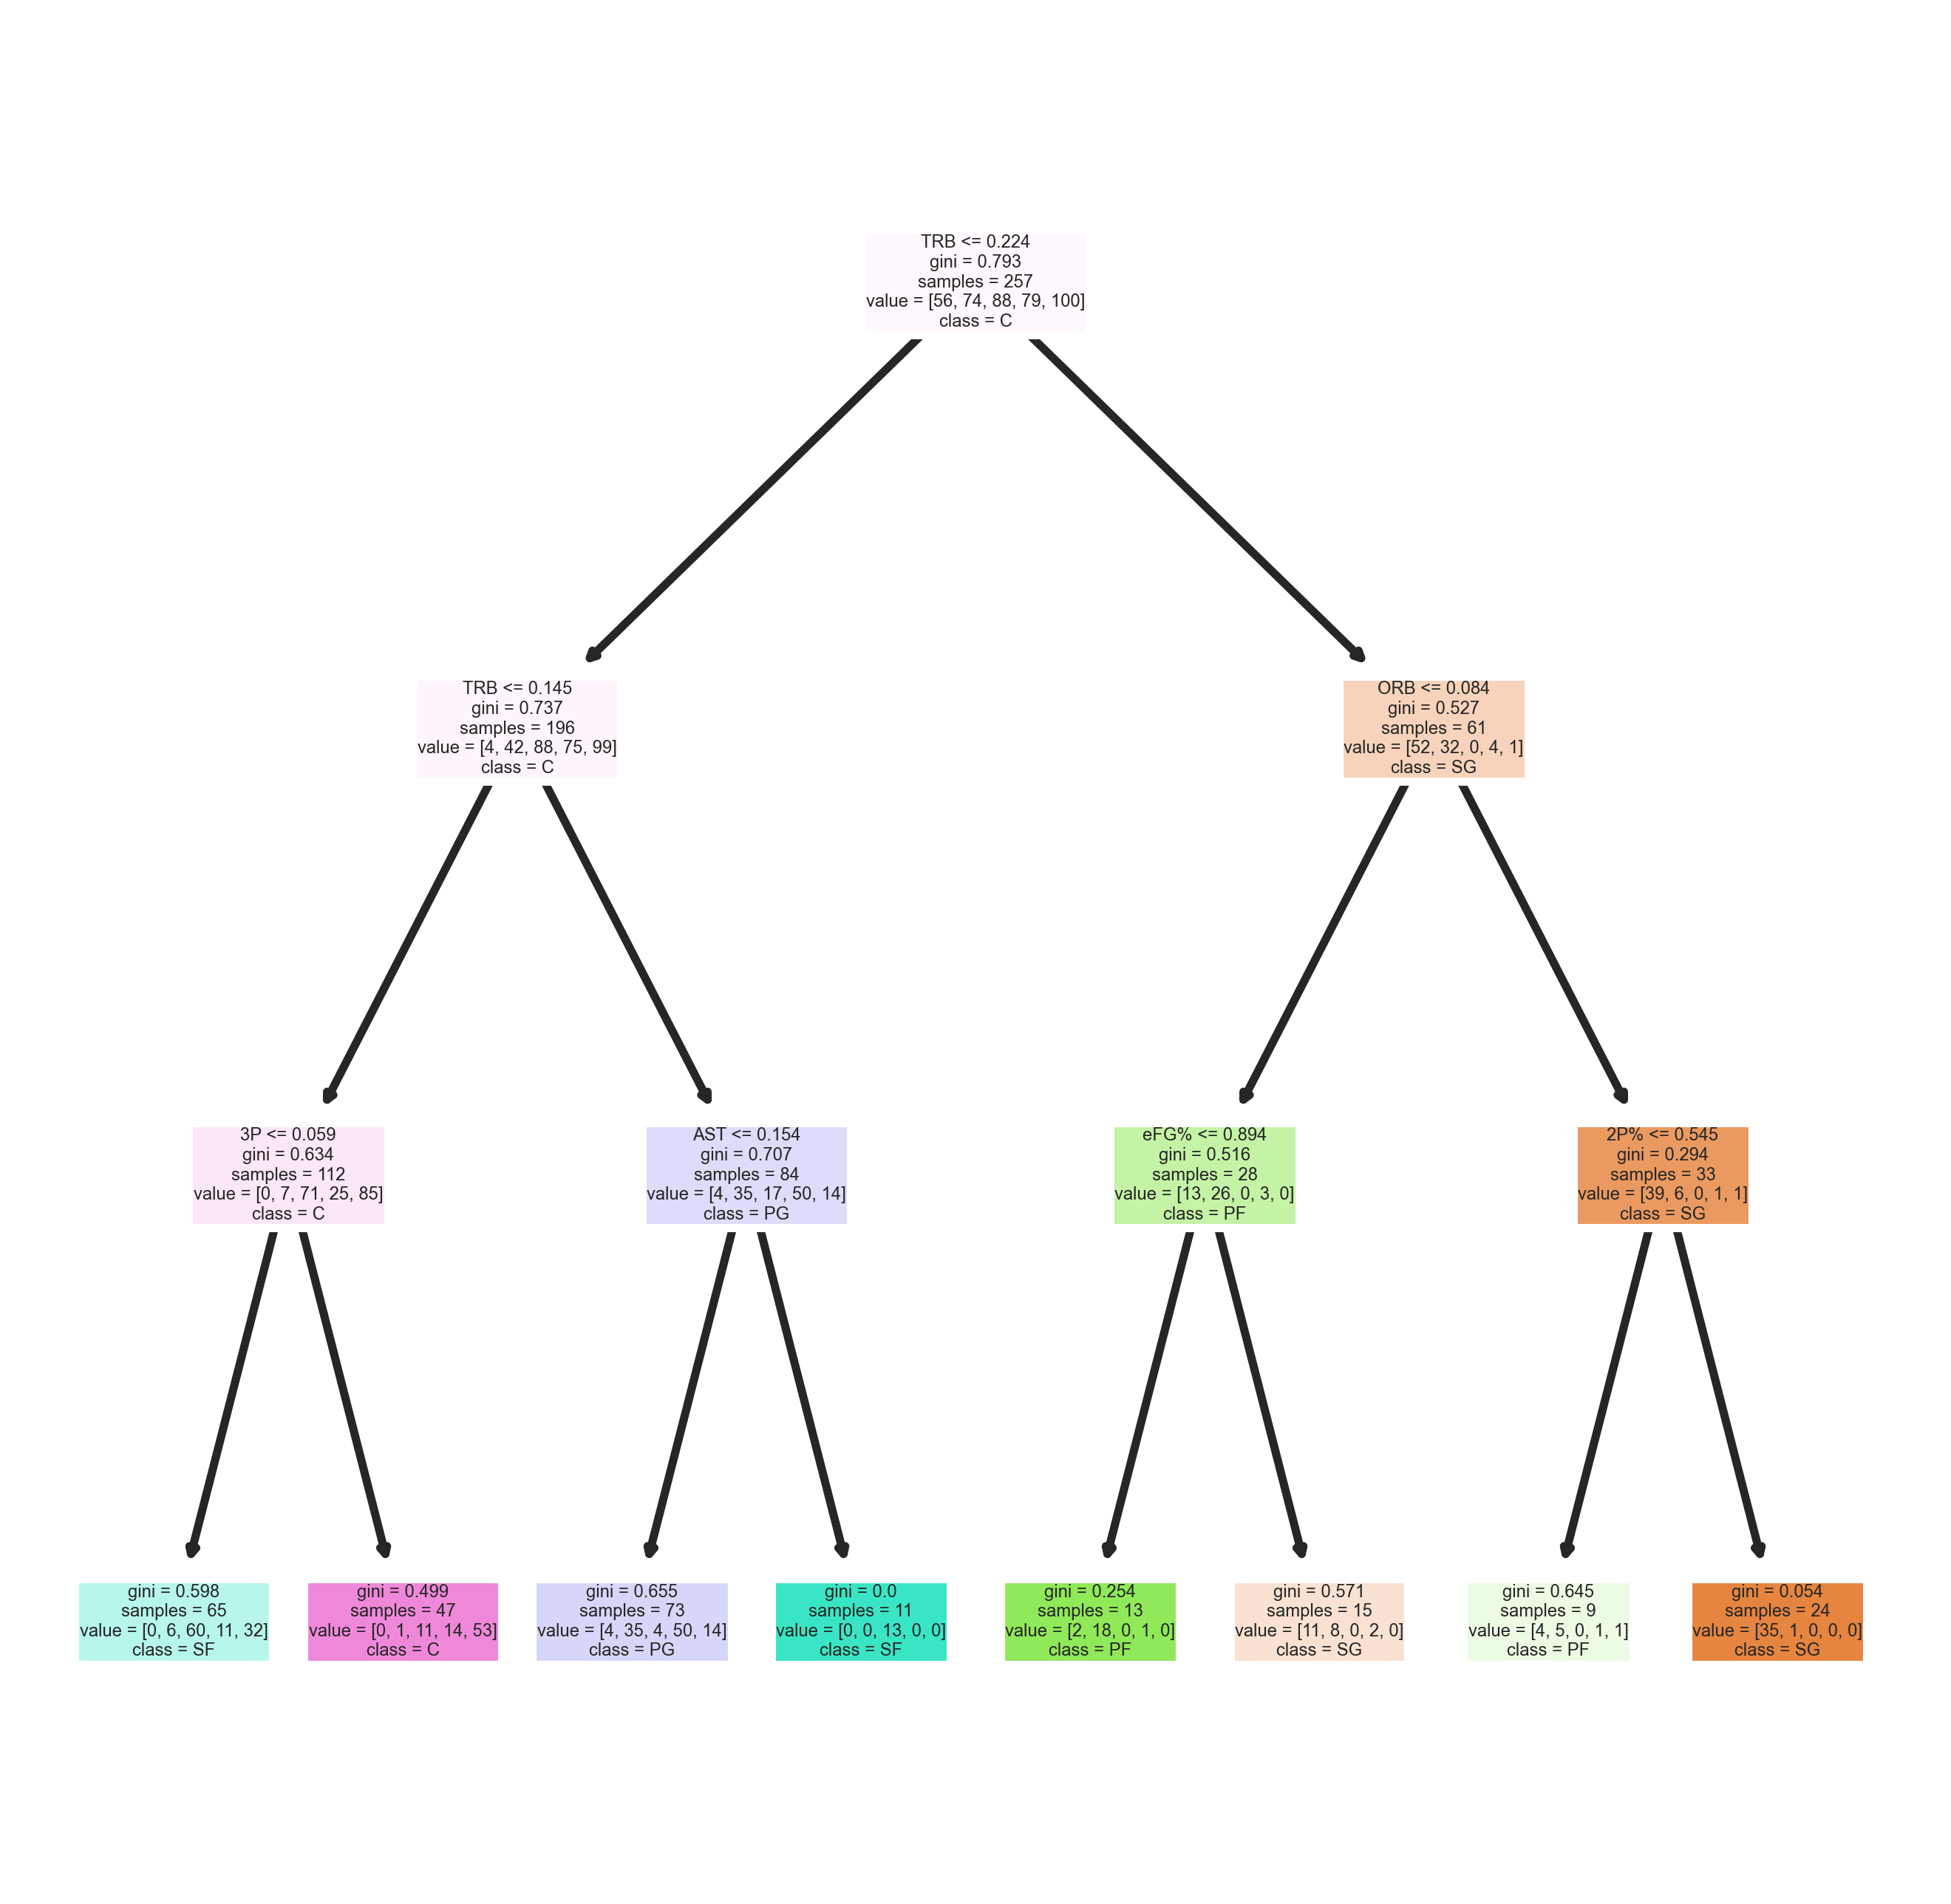

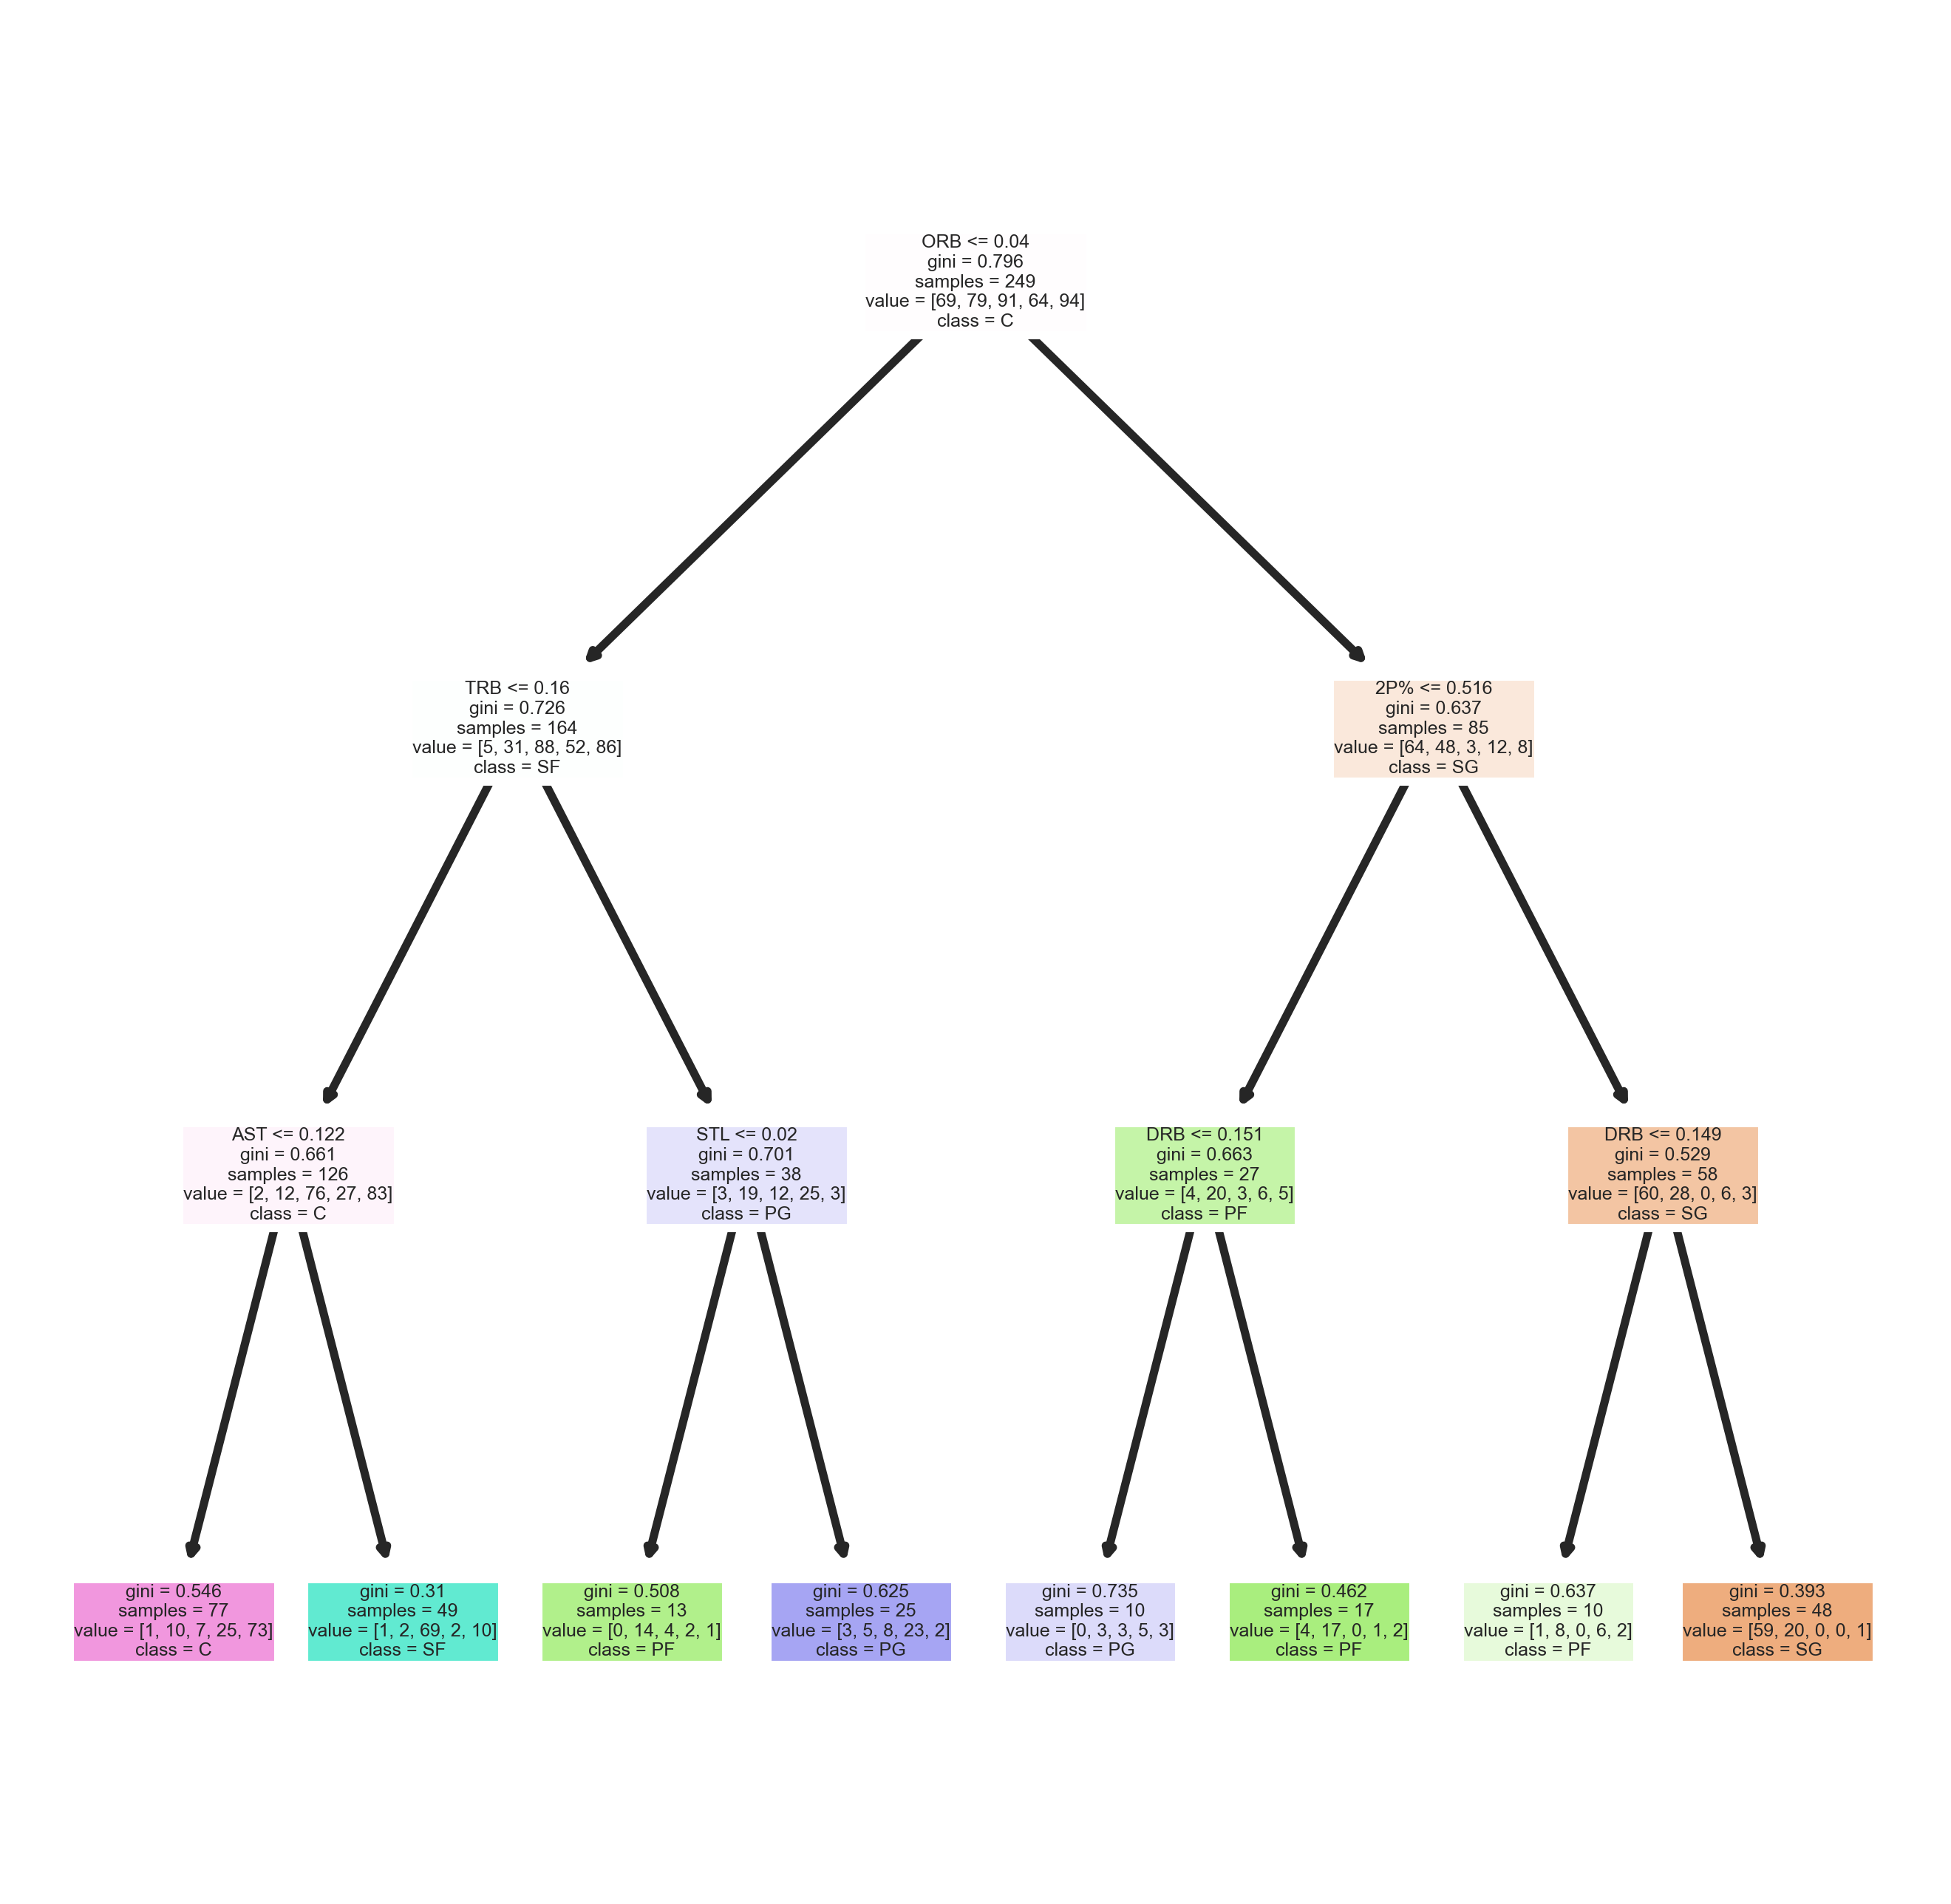

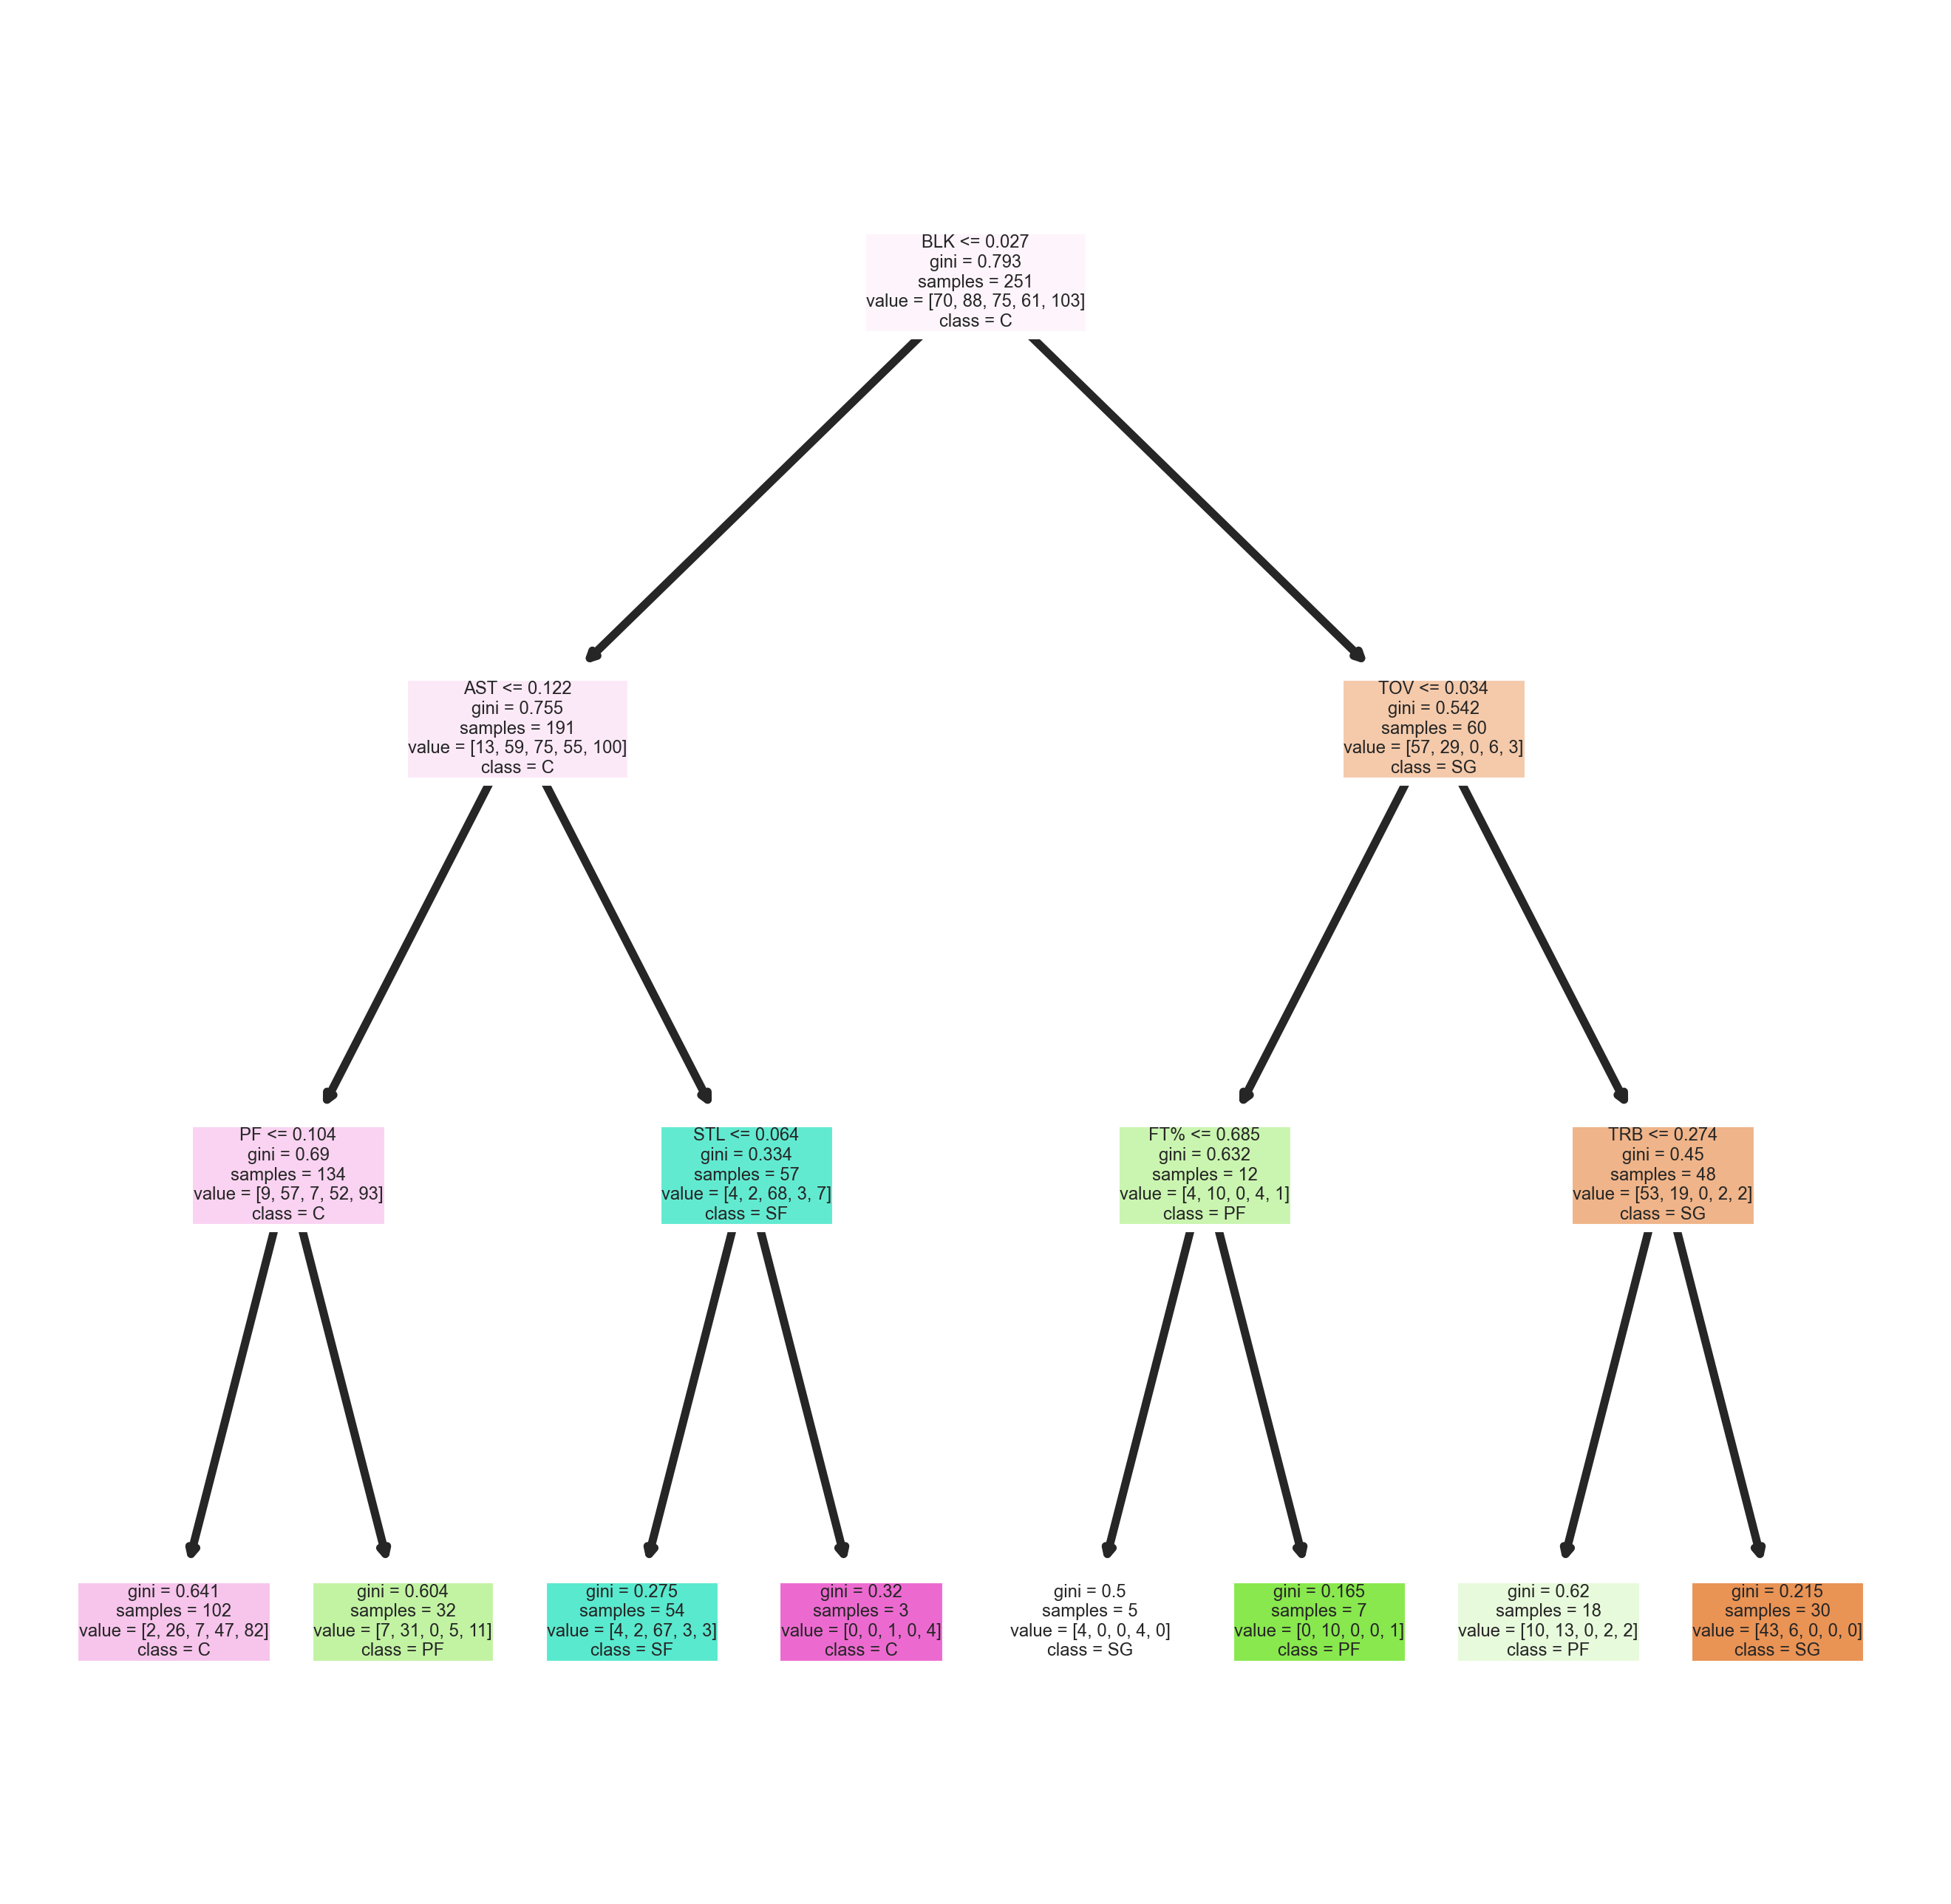

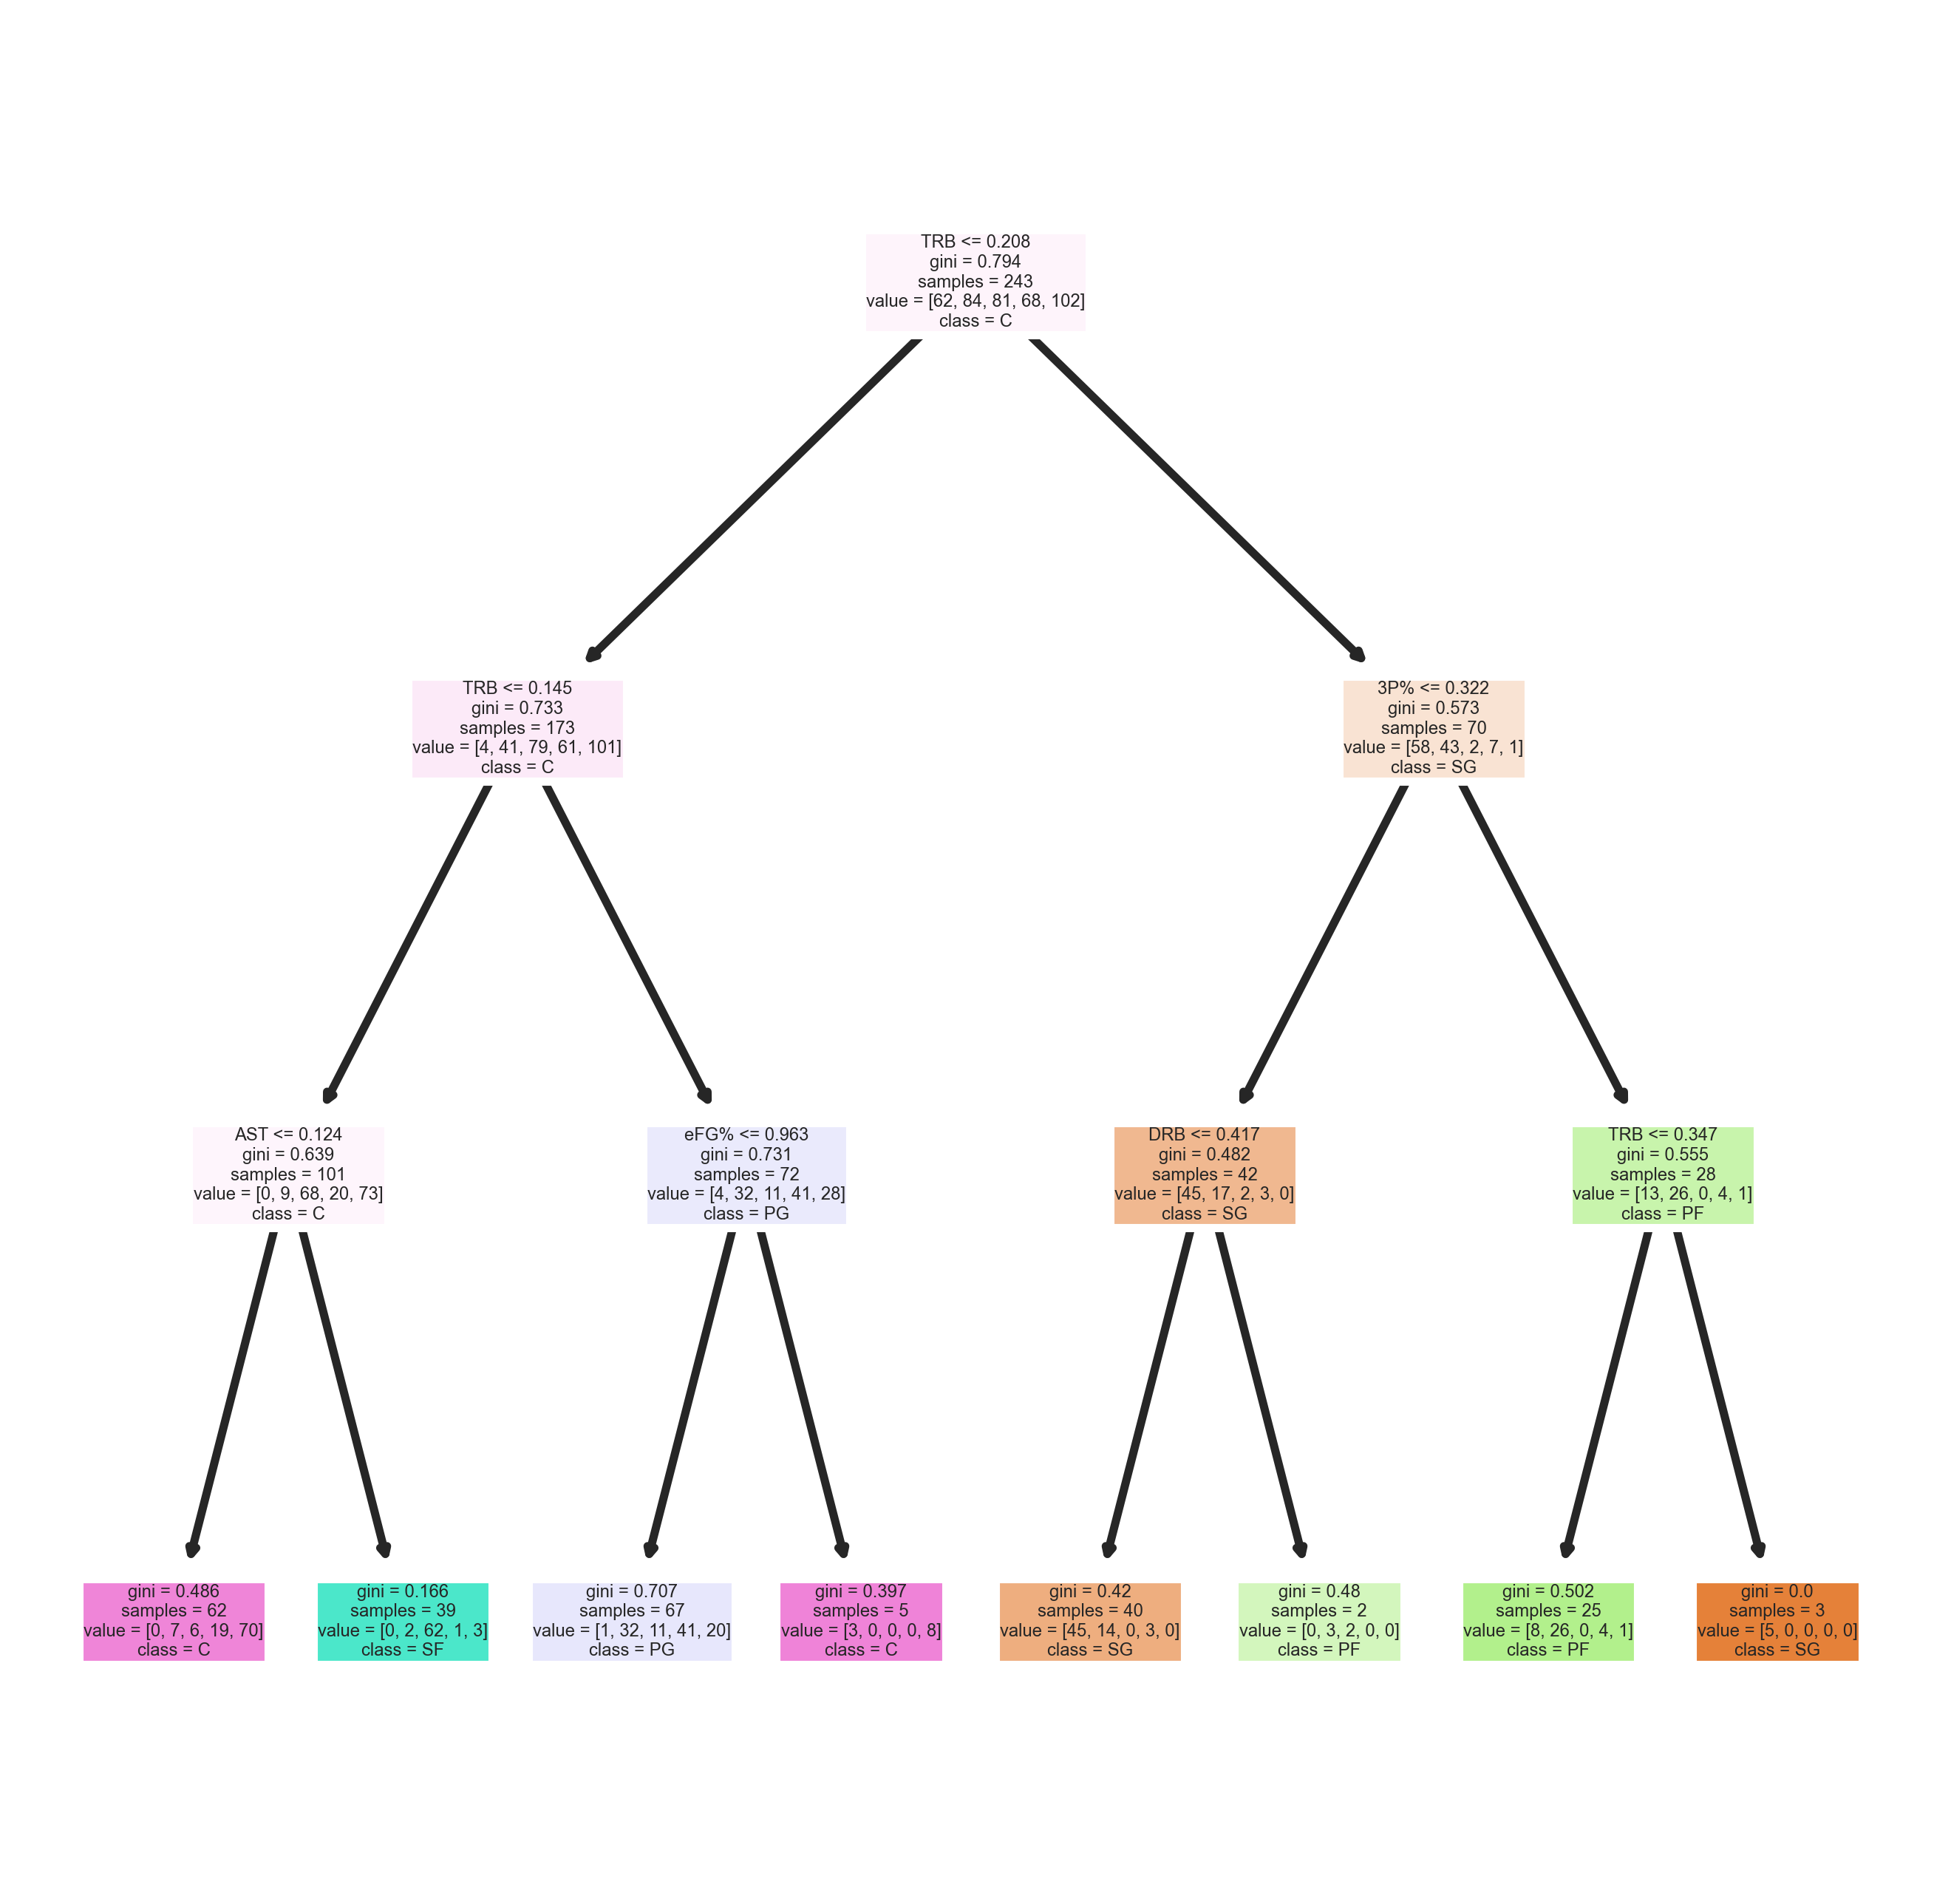

In [29]:
from sklearn import tree

import numpy as np
a = np.array(y_test.unique())
a = a.astype('<U10')
a

for x in range (45, 50):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
    tree.plot_tree(clf.estimators_[x],
                   feature_names = X.columns, 
                   class_names = a,
                   filled = True);

Different metrics can be used to see how a Random Forest Classifier performs, with these being the same as for the Decision Tree classifier. Instead of going through them all individually again, we can print out the entire metric as one. For information on each of these please see [here](https://towardsdatascience.com/introduction-to-decision-tree-classifiers-from-scikit-learn-32cd5d23f4d) 

In [30]:
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
oob_score = clf.oob_score_

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The out of basket score is: {oob_score:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

The training score of the random forest classifier is : 0.695
The out of basket score is: 0.640
The test score of the random forest classifier is 0.639


In [31]:
from sklearn import metrics

print (metrics.classification_report(y_test, test_pred_random_forest))

              precision    recall  f1-score   support

           C       0.76      0.88      0.81        25
          PF       0.55      0.71      0.62        24
          PG       0.69      0.67      0.68        27
          SF       0.50      0.15      0.23        20
          SG       0.61      0.68      0.64        37

    accuracy                           0.64       133
   macro avg       0.62      0.62      0.60       133
weighted avg       0.63      0.64      0.62       133



We can compare this to a DummyClassifier which uses simple rules in order to make predictions. This can be used as a simple baseline to compare with real classifiers. 

We can see here that the overall accuracy has increased from 0.28 to 0.64. This suggests that our model performs much better than simple decision rules and thus we can be confident in our model. However, an accuracy of 0.64 is quite low for a classification project so there is a lot that we are still missing. This could be due to the data that we have or down to our actual model.

To be able to test our model and see if we can improve it further, we could start by removing any uncessary features and tune the hyperparameters of our model.

## Feature importance

What is good about the Random Forest Classifier, as compared to a single Decision Tree is that we can examine the feature importance more closely. This is because when creating an individual Decision Tree then the algorithm may focus quite heavily on one part of the data than another in that particular instance and thus this would have high importance. However, when running multiple decision trees we can more clearly identify which features are more important. 

The importance of that feature is determined by the depth of that feature in respect to the predictability of the trget variables. Features that are at the top of the tree contribute to the final decision on a large number of input samples. By creating multiple trees, we can use the average predictive ability of the features in order to reduce variance that would be associated with feature importance if we were using an individual tree.

From this understanding, we can remove features that are not important and re-run the models again or just use this information to understand which features are important for our model. 

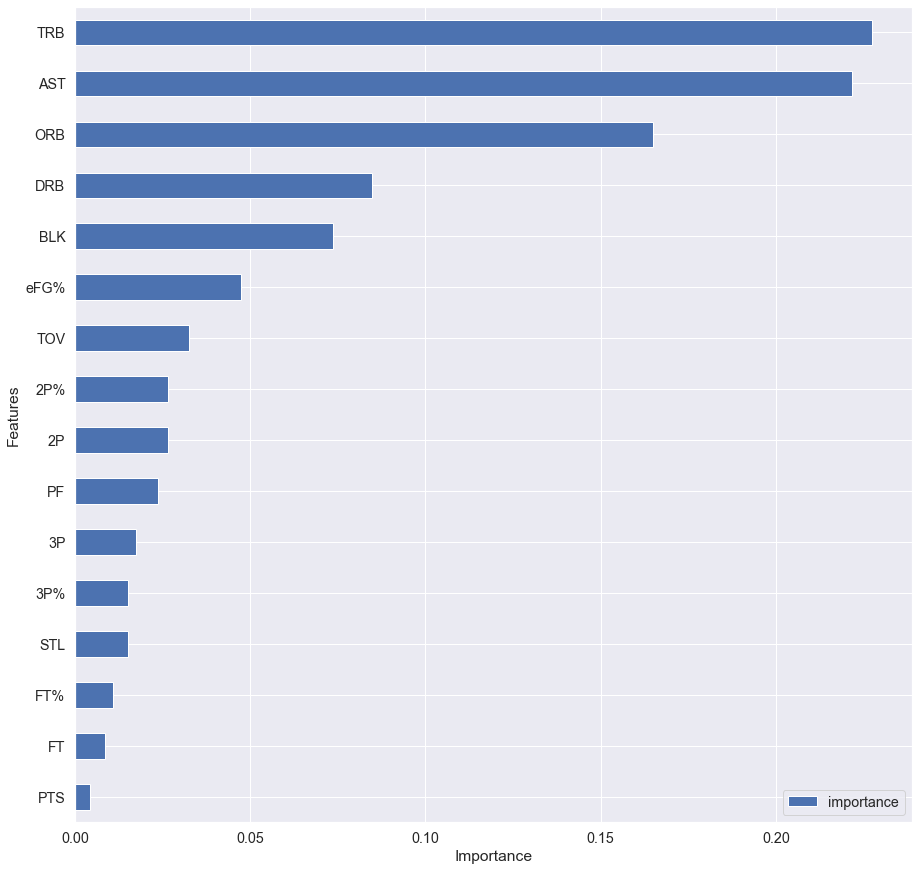

In [32]:
#print(clf.feature_importances_)
fi = pd.DataFrame({'feature': list(X.columns),
                  'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending=True)

plot = fi.plot.barh(x = 'feature', y = 'importance', figsize=(15,15))
plot.set_ylabel("Features")
plot.set_xlabel("Importance")

fig = plot.get_figure()
#fig.savefig("Plots/feature_importance_rf.png", bbox_inches='tight')

Our results here show that 6 features are highly informative while the remaining 11 are less so. We could make the decision here to remove these uninformative features and rerun it again, or we can keep them. Usually you would have a threshold for removing features from the model such as 1% or we could even generate a random feature for which if actual features perform worse than this we can remove them.

We can extract features that have less than a given importance using the following code:

In [33]:
fi[fi.importance <= 0.01]

,feature,importance
11,PTS,0.004175
2,FT,0.008507


## Permutation importance

Another method of looking at the importance of features is by using random re-shuffling to see how each individual rpedict influences model approaches. This does so by training the baseline model, recording the score (in this case the r^2 score). Then reshuffle the values from one feature in the dataset and rerun the predictions. The feature importance here is the difference between the becnhmark score and the modified score, thus the higher the value the more important the feature is for the model. 

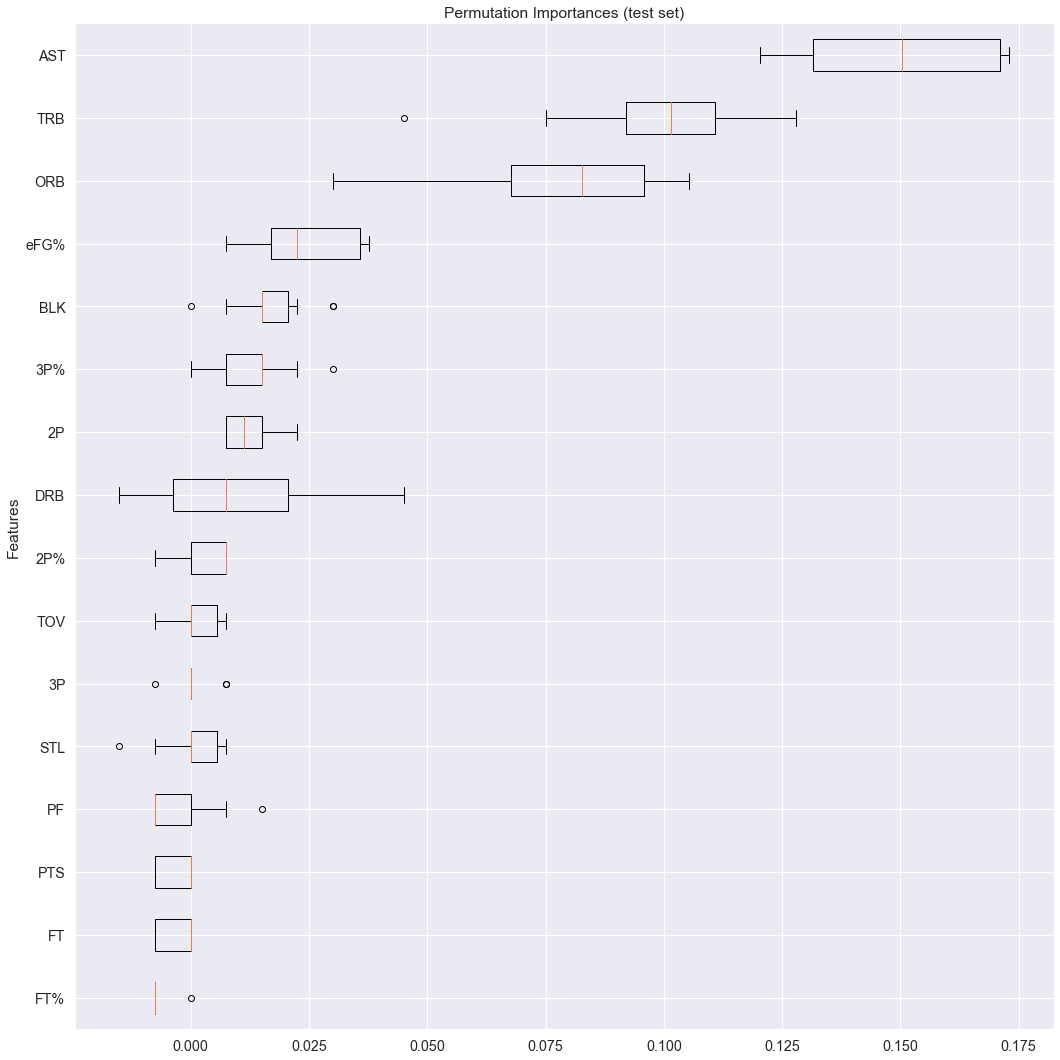

In [34]:

from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,15))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_ylabel("Features")
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

From this we can similar results to the feature importance results. It shows that essentially free throws attempted, steals, free throws and points add nothing to the analysis and in the case of free throws attempted evern make the results worse. 

Based on this therefore we can create a decision rule to drop certain data from the model to ensure that it is not overfitting and potentially increase the accuracy on the test set. For this, we will take the results from the feature importance results and drop any results that have an importance of less than 2% as follows, rerunning the analysis and seeing how it performs.

In [35]:
UIC =[]
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] <= 0:
        UIC.append(X.columns.values[i])
    
print(UIC)

['PF', 'PTS', 'FT', 'FT%']


In [36]:
#extracting unimportant features
UIF = list(fi[fi.importance <= 0.01].feature)

X_trainIF = X_train.drop(columns = UIF)
X_testIF = X_test.drop(columns = UIF)

clf.fit(X_trainIF, y_train)
test_pred_random_forest_IF = clf.predict(X_testIF)

train_accuracy = clf.score(X_trainIF, y_train)
test_accuracy = clf.score(X_testIF, y_test)
oob_score = clf.oob_score_

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The out of basket score is: {oob_score:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

print (metrics.classification_report(y_test, test_pred_random_forest_IF))


The training score of the random forest classifier is : 0.693
The out of basket score is: 0.630
The test score of the random forest classifier is 0.639
              precision    recall  f1-score   support

           C       0.77      0.80      0.78        25
          PF       0.49      0.75      0.59        24
          PG       0.69      0.67      0.68        27
          SF       0.67      0.10      0.17        20
          SG       0.66      0.73      0.69        37

    accuracy                           0.64       133
   macro avg       0.65      0.61      0.58       133
weighted avg       0.66      0.64      0.61       133



In [37]:
X_trainIF_perm = X_train.drop(columns = UIC)
X_testIF_perm = X_test.drop(columns = UIC)

clf.fit(X_trainIF_perm, y_train)
test_pred_random_forest_IF = clf.predict(X_testIF_perm)

train_accuracy = clf.score(X_trainIF_perm, y_train)
test_accuracy = clf.score(X_testIF_perm, y_test)
oob_score = clf.oob_score_

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The out of basket score is: {oob_score:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

print (metrics.classification_report(y_test, test_pred_random_forest_IF))


The training score of the random forest classifier is : 0.700
The out of basket score is: 0.635
The test score of the random forest classifier is 0.647
              precision    recall  f1-score   support

           C       0.80      0.80      0.80        25
          PF       0.50      0.79      0.61        24
          PG       0.69      0.67      0.68        27
          SF       0.67      0.10      0.17        20
          SG       0.66      0.73      0.69        37

    accuracy                           0.65       133
   macro avg       0.66      0.62      0.59       133
weighted avg       0.66      0.65      0.62       133



As we can see here, actually removing the number of variables from our model has increase the overall accuracy in the case of permutation importance, from 0.64 to 0.65. Thus, the other variables were simply reflecting noise and actually harming our model, albeit this is only a small increase.

We could even try to increase our threshold for dropping features, but for now we can go ahead and see if we can make further improvements through tuning the hyperparameters.

# Tune the hyperparameters

So now that we have the model, we can see that the accuracy still isn't that high and that there is still some overall confusion from the model. We have tried removing variables that could be disrupting how the model performs, the next stage is to then change the model itself by tuning the hyperparameters. We have done this before with a decision tree and essentially it is the same process, searching for the most efficient results based on a given grid.

For this we are choosing to change the max_depth and the min_samples split, and feeding these optimal values back into the model.

In [38]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [4,5,6,7,8], 
                     'min_samples_split': [1,3,5,7,9]}]

scores = ['accuracy']

for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters,
        scoring = f'{score}'
    )
    clf.fit(X_trainIF, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")


Tuning hyperparameters for accuracy



C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 7

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 7

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 7

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 7

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\joblib\parallel.py", line 7

Best parameters set found on development set:

{'max_depth': 7, 'min_samples_split': 5}

Grid scores on development set:
nan (+/-nan) for {'max_depth': 4, 'min_samples_split': 1}
0.640 (+/-0.044) for {'max_depth': 4, 'min_samples_split': 3}
0.647 (+/-0.029) for {'max_depth': 4, 'min_samples_split': 5}
0.640 (+/-0.073) for {'max_depth': 4, 'min_samples_split': 7}
0.635 (+/-0.019) for {'max_depth': 4, 'min_samples_split': 9}
nan (+/-nan) for {'max_depth': 5, 'min_samples_split': 1}
0.647 (+/-0.036) for {'max_depth': 5, 'min_samples_split': 3}
0.642 (+/-0.026) for {'max_depth': 5, 'min_samples_split': 5}
0.645 (+/-0.041) for {'max_depth': 5, 'min_samples_split': 7}
0.635 (+/-0.064) for {'max_depth': 5, 'min_samples_split': 9}
nan (+/-nan) for {'max_depth': 6, 'min_samples_split': 1}
0.642 (+/-0.067) for {'max_depth': 6, 'min_samples_split': 3}
0.650 (+/-0.045) for {'max_depth': 6, 'min_samples_split': 5}
0.632 (+/-0.037) for {'max_depth': 6, 'min_samples_split': 7}
0.645 (+/-0.062) for {'

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.63977848 0.64740506 0.63977848 0.63471519        nan
 0.64734177 0.64231013 0.64481013 0.63484177        nan 0.64221519
 0.64981013 0.6321519  0.64484177        nan 0.63984177 0.65990506
 0.65496835 0.64993671        nan 0.64474684 0.62721519 0.63477848
 0.62981013]
  warnings.warn(


We can use different metrics or even different ways of scoring this. For different ways of scoring this we could use:

In [39]:

sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

However, for now lets take these ideas forward to see what the outcome is when we use the values that come out of the grid serach results:

In [40]:
clf = RandomForestClassifier(n_estimators =100, oob_score=True, 
                             max_depth =clf.best_params_["max_depth"], 
                             min_samples_split = clf.best_params_['min_samples_split'],
                            random_state = 42)


clf.fit(X_trainIF, y_train)
test_pred_random_forest = clf.predict(X_testIF)



In [41]:
train_accuracy = clf.score(X_trainIF, y_train)
test_accuracy = clf.score(X_testIF, y_test)

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

The training score of the random forest classifier is : 0.924
The test score of the random forest classifier is 0.639


In [42]:
from sklearn import metrics

print (metrics.classification_report(y_test, test_pred_random_forest))

              precision    recall  f1-score   support

           C       0.74      0.68      0.71        25
          PF       0.53      0.75      0.62        24
          PG       0.75      0.67      0.71        27
          SF       0.47      0.40      0.43        20
          SG       0.69      0.65      0.67        37

    accuracy                           0.64       133
   macro avg       0.63      0.63      0.63       133
weighted avg       0.65      0.64      0.64       133



We can see now that we have removed any unecessary features and tuned the hyperparamaters, our model overall accuracy barely improved, if at all. 

From this there are a few different conclusions we could draw.
1. We could say that the data we have is not well suited to this method. Indeed, we could collect better data, such as more advanced statistic measures, or we could expand our data search to see if there was more data out there such as using different years. This would hopefully tell us more than what we have.
2. We could say that this shows that the current NBA is 'positionless' to a degree. The fact that our model hasn't been able to predict the position well suggests that positions aren't clearly defined. Looking at the confusion matrix however we can see that a centre is not confused with a point guard at any point so that there is clearly some defintion, and our model has an accuracy of 0.64 the league is clearly not fully 'positionless'
3. We could say that this particular algorithm is not working and thus we could see whether different methods are may improve this, such as a single decision tree, nearest neighbour algorithms or neural nets. 

If you wanted to look further try seeing if:
1. You could tell me what oob_score is checking and why it is important
2. Try running the algorithm on data from another year
3. Compare these results to the results you would get if you had used a single decision tree